In [3]:
#Import libraries
import rdata
import os
import networkx as nx
import pandas as pd
import networkx.algorithms.community as nx_comm
from pyvis.network import Network
import numpy as np
import matplotlib.pyplot as plt
import random
from datetime import datetime
from collections import Counter

# Enable multiple outputs of a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [5]:
#read data and extract edgeList and twitter account data.
#Please Map the location of Dataset present in your system to parse.
result = rdata.parser.parse_file("trolls.Rdata") 
data = rdata.conversion.convert(result)

mel = data['trolls']['mel']
userData = pd.DataFrame(data['trolls']['val'])

edgeList = []
for edge in mel:
    p1 = edge['inl'][0]
    p2 = edge['outl'][0]
    edgeList.append([p1,p2])

/Users/rohanjadhav/anaconda3/lib/python3.11/site-packages/rdata/conversion/_conversion.py:887: UserWarning: Missing constructor for R class "network". The underlying R object is returned instead.
  warnings.warn(


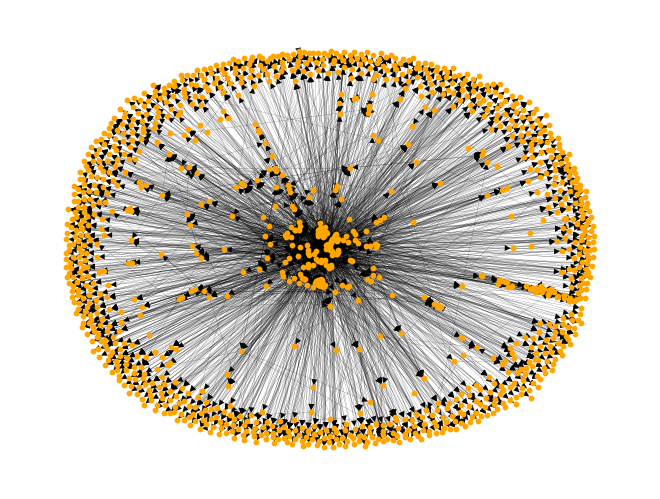

In [3]:
#Plot the whole graph using edgeList. Adjust node color & size, edge width, to visualise better.
G = nx.DiGraph()
G.add_edges_from(edgeList)
nx.draw(G, with_labels=False, node_size=10, width=0.1, node_color='orange')

In [4]:
#Finiding top 10 partitions/communities who mention amoung themselves on twitter
partition = list(nx_comm.greedy_modularity_communities(G))[0:10]

#Note: The partitions except top 10 are very small, which contain 2-10 nodes comapared to other partition of 
#50-600 nodes, so they are ignored for study here.

In [5]:
#Get the degree of nodes, sort them from highest degree to lowest degree.
degree_list = list(G.degree())
sorted_degree_list = sorted(degree_list, key=lambda x: x[1], reverse=True)
maxDegreeNodes = [node[0] for node in sorted_degree_list]

#From user data pick the category of the top 10 partitions for analysis.
def getpartitionUserCategory(part):
    count = 0
    top_10_nodes_from_part = []
    for node in part:
        # Check if the node is in maxDegreeNodes
        if node in maxDegreeNodes:
            top_10_nodes_from_part.append(node-1)
            count += 1
        # If we have found the top 10 nodes, break the loop
        if count == 10:
            break
    return userData.iloc[top_10_nodes_from_part]
    

In [6]:
#Here we are creating a dictionary which maps the partition to corresponding category
categoryList = []
for i in range(0,10):
    categoryList.append(getpartitionUserCategory(partition[i])['accounttype'].tolist()[0])

part = []
for p in partition:
    part.append(len(p))
    
partitionCategoryMap = {}
for i in range(0,10):
    partitionCategoryMap[part[i]] = categoryList[i][0]
partitionCategoryMap

{523: 'Russian',
 267: 'Right',
 128: 'left',
 92: 'Hashtager',
 56: 'Russian',
 43: 'German',
 35: 'Russian',
 10: 'Russian',
 8: 'news',
 7: 'Right'}

In [7]:
#Since we have edgeList which has all the edges of the network. For analysis of partition, we need their respective
#edgelist, so this method returns edgelist of partitions based on their index n in parition list.
#Basically it gets edges for nodes present in parition.
def GetEdgeListForPartition(n):
    partitionEdgeList = []
    for node in partition[n]:
        for edge in edgeList:
            if((edge[0]==node) or (edge[1]==node)):
                partitionEdgeList.append(edge)
    return partitionEdgeList

In [8]:
#For plotting purpose few distinct colors are chones and each color here is assigned to respective partition nodes.
colList = ['red', 'green', 'blue', 'yellow', 'purple', 'orange', 'cyan', 'magenta', 'brown', 'lime']
partitionDict = {}

count=0
for partNodes in partition[0:10]:
    partitionDict[colList[count]] = partNodes
    count = count+1

#This method is defined to return the color of the node which will be used while plotting.    
def get_key_by_value(my_dict, target_value):
    for key, value in my_dict.items():
        for n in value:
            if n == target_value:
                return key
    return 'white'  # Return White if the value is not found in the dictionary

In [9]:
partitionNodes = []
for part in partition:
    for node in part:
        partitionNodes.append(node)
        
partitionedEdgeList = edgeList

#since we are plotting only top 10 nodes, we will be removing edges from remanining partitons.
for edge in partitionedEdgeList:
    if edge[0] not in partitionNodes and edge[1] not in partitionNodes:
        partitionedEdgeList.remove(edge)

#Create graph with top 10 partitions to plot.        
G_parts = nx.Graph()            
G_parts.add_edges_from(partitionedEdgeList)

#Create list of node colors based on paritions.
nodeColor = []
for i in G_parts.nodes():
    nodeColor.append(get_key_by_value(partitionDict, i))

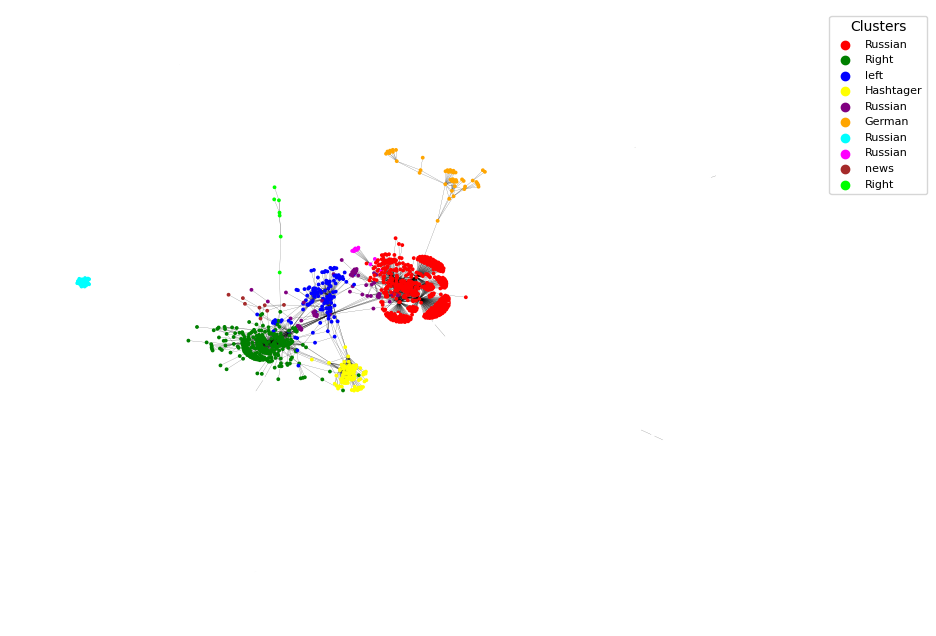

In [10]:
#Plotting the graph with partitions denated by different colors.
legend_dict = {}
color_index = 0
fig, axes = plt.subplots(1, 1, figsize=(10, 8))

labelsDict = {}
for i in range(0,10):
    labelsDict[colList[i]] = categoryList[i][0]

for color, category in labelsDict.items():
    plt.scatter([], [], color=color, label=category)

nx.draw(G_parts, with_labels=False, node_color=nodeColor, font_size=8, node_size=3, width=0.1, edge_color='black')
#Adding legend of Partition categories.
plt.legend(title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size': 8})
plt.show()

In [11]:
# Maxdegree nodes in complete network

degree_list = list(G_parts.degree()) #Degree of all the nodes
sorted_degree_list = sorted(degree_list, key=lambda x: x[1], reverse=True)[:10] #Node Degree list sorted and only top 10 selected
maxDegreeNodes = [node[0] for node in sorted_degree_list] #Taking the node IDs from top 10 node degree list

md_node_color = ['steelblue' if i in maxDegreeNodes else 'orange' for i in G_parts.nodes()] #setting color for max degree nodes
md_node_size = [30 if i in maxDegreeNodes else 1 for i in G_parts.nodes()] #setting node size for max degree nodes
highlight_edges = [(u, v) for u, v in G_parts.edges() if u in maxDegreeNodes and v in maxDegreeNodes] #getting the edgelist b/w max degree nodes
md_edge_colors = ['red' if edge in highlight_edges else 'grey' for edge in G_parts.edges()]  #setting color for edges b/w max degree nodes
md_edge_width = [1 if edge in highlight_edges else 0.1 for edge in G_parts.edges()] #setting edge width for edges b/w max degree nodes

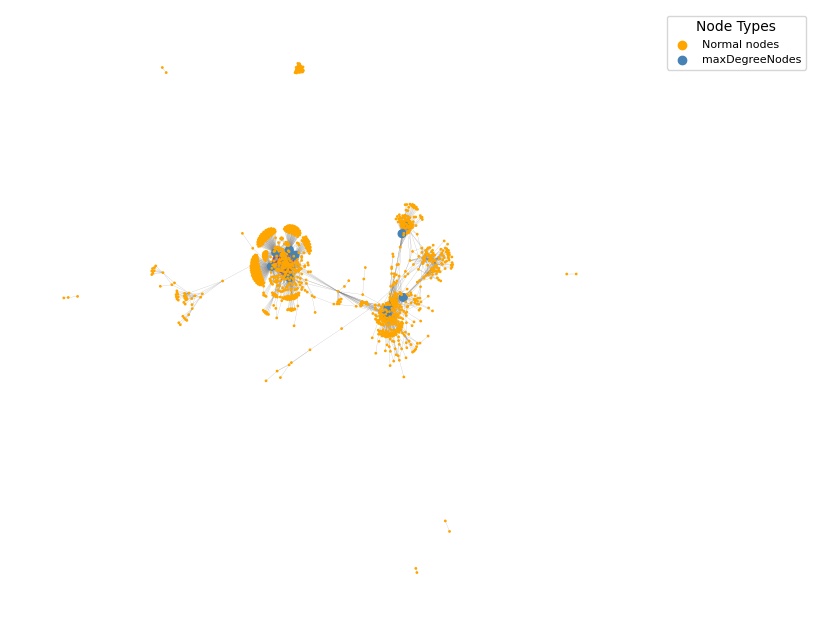

In [12]:
# Plotting the graph
fig, axes = plt.subplots(1, 1, figsize=(8, 8)) 
labelsDict = {'orange':'Normal nodes', 'steelblue':'maxDegreeNodes'}

# Create a scatter plot with fake data to display the legend
for color, category in labelsDict.items():
    plt.scatter([], [], color=color, label=category)

nx.draw(G_parts, with_labels=False, node_color=md_node_color, node_size=md_node_size, width=md_edge_width, edge_color = md_edge_colors)
plt.legend(title='Node Types', bbox_to_anchor=(1.05,1), loc='upper left', prop={'size': 8}) #creating the legend
plt.savefig('maxDegreeNodes.png', dpi=300, bbox_inches='tight')

In [13]:
#Max edge_betweenness_centrality in complete network

#Getting the top 10 edges with highest edge betweenness centrality
edgeBetweenness_centrality = sorted(nx.edge_betweenness_centrality(G_parts), key=lambda x: x[1], reverse=True)[0:10]

node_list = list(G_parts.nodes()) 
#setting the color for edges with highest edge betweenness centrality
eb_edge_colors = ['red' if any(node == elem[0] or node == elem[1] for elem in edgeBetweenness_centrality) else 'black' for node in node_list]
#setting the width for edges with highest edge betweenness centrality
eb_edge_width = [1 if any(node == elem[0] or node == elem[1] for elem in edgeBetweenness_centrality) else 0.1 for node in node_list]

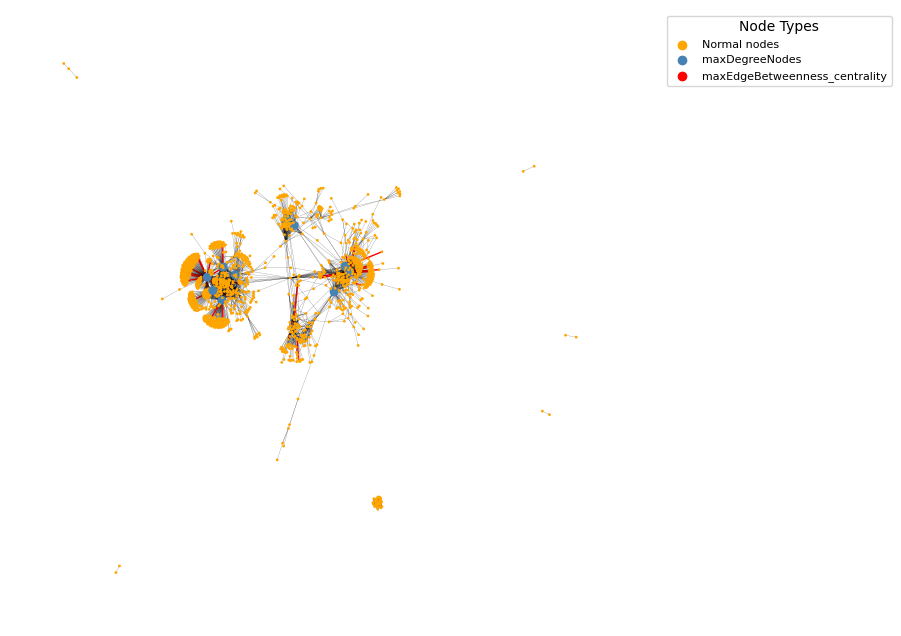

In [14]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
labelsDict = {'orange':'Normal nodes', 'steelblue':'maxDegreeNodes','red':'maxEdgeBetweenness_centrality'} #creating color dictionary for legend

# Create a scatter plot with fake data to display the legend
for color, category in labelsDict.items():
    plt.scatter([], [], color=color, label=category)
nx.draw(G_parts, with_labels=False, node_color=md_node_color, node_size=md_node_size, width=eb_edge_width, edge_color = eb_edge_colors)
plt.legend(title='Node Types', bbox_to_anchor=(1.05,1), loc='upper left', prop={'size': 8}) #legend for the graph
plt.savefig('edgeBetweenness_centrality.png', dpi=300, bbox_inches='tight')

In [15]:
#Most significant partition P1 (highest modularity)

P1_edges = GetEdgeListForPartition(0) #partition with the highest modularity
P1 = nx.Graph()
P1.add_edges_from(P1_edges)

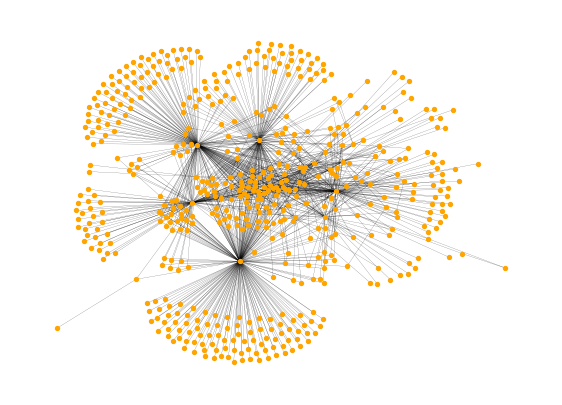

In [16]:
#Visualising most significant partition P1
fig, axes = plt.subplots(1, 1, figsize=(7, 5)) #setting the figure size
nx.draw(P1, with_labels=False, node_size=8,node_color='orange', width=0.1, edge_color='black')
plt.savefig('MaxModularity_Partition.png', dpi=300, bbox_inches='tight')

In [17]:
#Some mathematical properties of P1

print("Number of nodes in P1 (partition with highest modularity)", len(list(P1.nodes))) #no of nodes in P1
print("Number of edges in P1 (partition with highest modularity)", len(list(P1.edges))) #no of edges in P1
print("Density of P1 is:", nx.density(P1)) #density of P1
print("Diameter of P1 is",nx.diameter(P1)) #Diameter of P1
print("Is the P1 connected:",nx.is_connected(P1)) #Checking if P1 is connected
degree = P1.degree() #Node degree of P1
P1_mean_degree = sum(dict(degree).values())/len(list(P1.nodes)) #Mean degree of P1
print("Mean Degree of P1 is",P1_mean_degree)

Number of nodes in P1 (partition with highest modularity) 553
Number of edges in P1 (partition with highest modularity) 1122
Density of P1 is: 0.007351206855884897
Diameter of P1 is 5
Is the P1 connected: True
Mean Degree of P1 is 4.057866184448463


In [18]:
# Max degree nodes in P1

P1_max_degree_list = list(nx.degree(P1)) #Degree of nodes in P1
P1_sorted_degree_list = sorted(P1_max_degree_list, key=lambda x: x[1], reverse=True)[:10] #top 10 Degree of P1
P1_maxDegreeNodes = [node[0] for node in P1_sorted_degree_list] #Node list with highest degree

P1_node_color = ['steelblue' if i in P1_maxDegreeNodes else 'orange' for i in P1.nodes()] #Setting the color of highest degree nodes of P1
P1_node_size = [100 if i in P1_maxDegreeNodes else 3 for i in P1.nodes()] #Setting the node size of highest degree nodes of P1

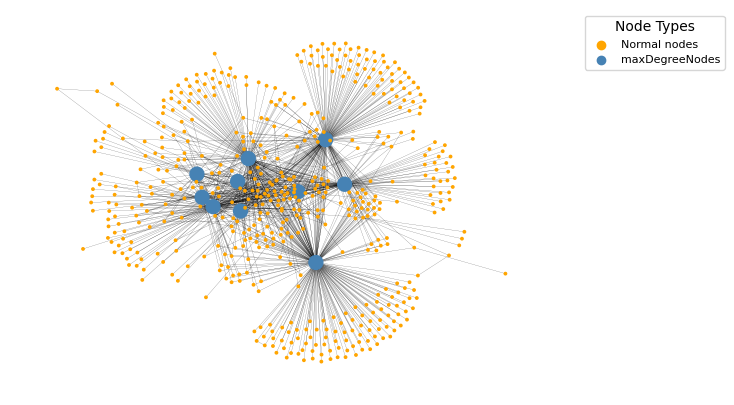

In [19]:
fig, axes = plt.subplots(1, 1, figsize=(7, 5)) #setting the figure size
labelsDict = {'orange':'Normal nodes', 'steelblue':'maxDegreeNodes'} #creating color dictionary for legend

# Create a scatter plot with fake data to display the legend
for color, category in labelsDict.items():
    plt.scatter([], [], color=color, label=category)
nx.draw(P1, with_labels=False, node_color=P1_node_color, node_size=P1_node_size, width=0.1) #Draw the network
plt.legend(title='Node Types', bbox_to_anchor=(1.05,1), loc='upper left', prop={'size': 8}) #Legend
plt.savefig('MaxDegeeNodes_P1.png', dpi=300, bbox_inches='tight')

In [20]:
#Closeness Centrality of P1
P1_closeness_centrality = nx.closeness_centrality(P1) #Closeness centrality of nodes in P1
P1_sorted_closeness_centrality = dict(sorted(P1_closeness_centrality.items(), key=lambda item: item[1], reverse=True)[:10]) #top 10 closeness centrality of P1
P1_maxClosenessNodes = list(P1_sorted_closeness_centrality.keys()) #Node list with highest closeness centrality

P1_cnode_color = ['steelblue' if i in P1_maxClosenessNodes else 'orange' for i in P1.nodes()] #Setting the color of highest closeness centrality nodes of P1
P1_cnode_size = [100 if i in P1_maxClosenessNodes else 3 for i in P1.nodes()] #Setting the node size of highest closeness centrality nodes of P1

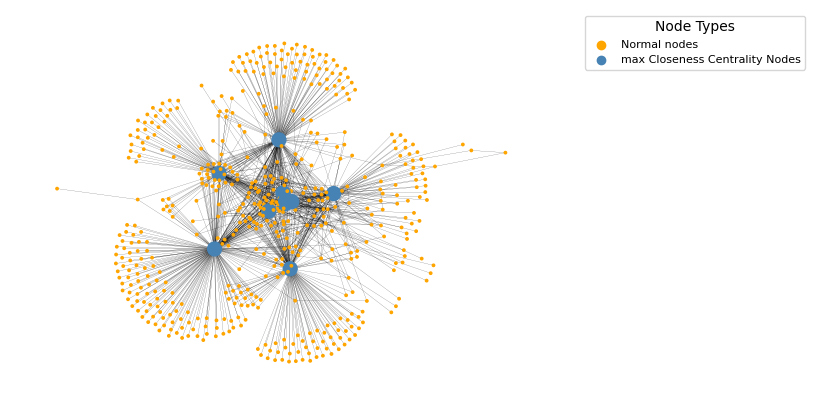

In [21]:
fig, axes = plt.subplots(1, 1, figsize=(7, 5)) #setting the figure size
labelsDict = {'orange':'Normal nodes', 'steelblue':'max Closeness Centrality Nodes'} #creating color dictionary for legend

# Create a scatter plot with fake data to display the legend
for color, category in labelsDict.items():
    plt.scatter([], [], color=color, label=category)
nx.draw(P1, with_labels=False, node_color=P1_cnode_color, node_size=P1_cnode_size, width=0.1) #Draw the network
plt.legend(title='Node Types', bbox_to_anchor=(1.05,1), loc='upper left', prop={'size': 8}) #Legend
plt.savefig('MaxClosenessCentralityNodes_P1.png', dpi=300, bbox_inches='tight')

In [22]:
#Betweenness Centrality of P1

P1_betweenness_centrality = nx.betweenness_centrality(P1) #Betweenness centrality of nodes in P1
P1_sorted_betweenness_centrality = dict(sorted(P1_betweenness_centrality.items(), key=lambda item: item[1], reverse=True)[:10]) #top 10 betweenness centrality of P1
P1_maxBetweennessNodes = list(P1_sorted_betweenness_centrality.keys()) #Node list with highest closeness centrality

P1_bnode_color = ['steelblue' if i in P1_maxBetweennessNodes else 'orange' for i in P1.nodes()] #Setting the color of highest betweenness centrality nodes of P1
P1_bnode_size = [100 if i in P1_maxBetweennessNodes else 3 for i in P1.nodes()] #Setting the nodesize of highest betweenness centrality nodes of P1

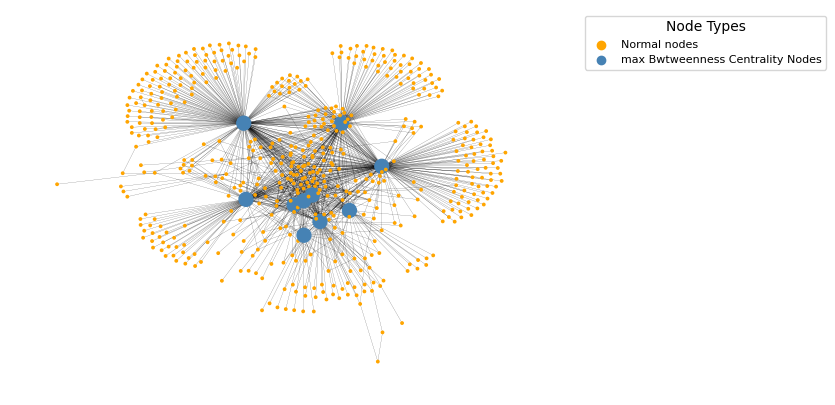

In [23]:
fig, axes = plt.subplots(1, 1, figsize=(7, 5)) #setting the figure size
labelsDict = {'orange':'Normal nodes', 'steelblue':'max Bwtweenness Centrality Nodes'} #creating color dictionary for legend

# Create a scatter plot with fake data to display the legend
for color, category in labelsDict.items():
    plt.scatter([], [], color=color, label=category)
nx.draw(P1, with_labels=False, node_color=P1_bnode_color, node_size=P1_bnode_size, width=0.1) #Draw the network
plt.legend(title='Node Types', bbox_to_anchor=(1.05,1), loc='upper left', prop={'size': 8}) #Legend
plt.savefig('MaxBwtweennessCentrality_Nodes_P1.png', dpi=300, bbox_inches='tight')

In [24]:
#Most significant K-core of P1

P1_kcore = list(nx.k_core(P1)) #most significant k-core

P1_knode_color = ['steelblue' if i in P1_kcore else 'orange' for i in P1.nodes()] #setting node color for the nodes in k-core
P1_knode_size = [50 if i in P1_kcore else 3 for i in P1.nodes()] #setting node size for the nodes in k-core

P1_highlight_edges = [(u, v) for u, v in P1.edges() if u in P1_kcore and v in P1_kcore] #getting the edge list for k-core
P1_edge_colors = ['red' if edge in P1_highlight_edges else 'black' for edge in P1.edges()]  #setting edge color for k-core edges
P1_edge_width = [1 if edge in P1_highlight_edges else 0.1 for edge in P1.edges()] #setting edge width for k-core edges


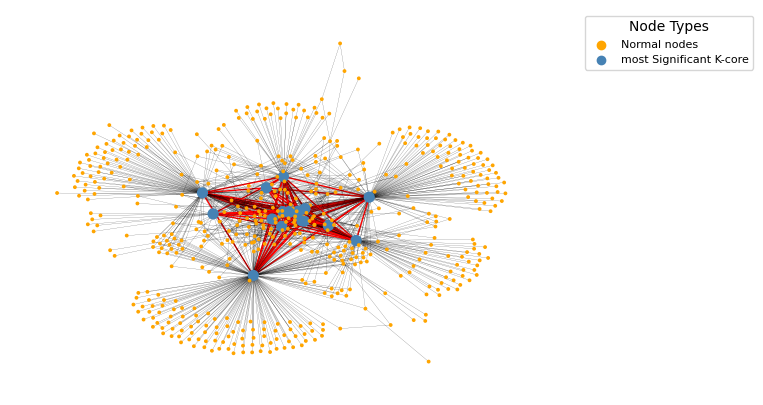

In [25]:
fig, axes = plt.subplots(1, 1, figsize=(7, 5)) #setting the figure size
labelsDict = {'orange':'Normal nodes', 'steelblue':'most Significant K-core'} #creating color dictionary for legend

# Create a scatter plot with fake data to display the legend
for color, category in labelsDict.items():
    plt.scatter([], [], color=color, label=category)
nx.draw(P1, with_labels=False, node_color=P1_knode_color, font_size=8, node_size=P1_knode_size, width=P1_edge_width, edge_color=P1_edge_colors)
plt.legend(title='Node Types', bbox_to_anchor=(1.05,1), loc='upper left', prop={'size': 8}) #Legend
plt.savefig('most Significant K-core_P1.png', dpi=300, bbox_inches='tight')

In [26]:
#Preprocess the date data. We are looking for range of 2015 to 2017. 
#Example of data from data: [2015-12-28 18:16:00], We do not need exact time of the day, we we just 
#extract the date for analysis purpose.
mindate = []
for i in userData['minpostdate']:
    mindate.append(pd.to_datetime(str(i).replace("[", "").replace("\'", "").replace("]", "").split()[0]))

In [27]:
#Analyse the date column.
userData['minDate'] = mindate
userData['minDate'].describe()

count                             1245
mean     2015-07-15 06:50:36.144578304
min                2012-02-02 00:00:00
25%                2015-05-17 00:00:00
50%                2015-06-22 00:00:00
75%                2015-07-15 00:00:00
max                2017-12-08 00:00:00
Name: minDate, dtype: object

In [28]:
#Since we have 4 quartiles, we will be plotting 4 graphs to check based on that the growth of network.
#Here we are creating the Graph based on the filtered node based on min post date.
def GetGraphsBasedOnMinPostDate(date, data, edgeListToFilter, dateCategory):
    threshold_date = pd.to_datetime(date)
    index_list = data[data[dateCategory] < threshold_date].index.tolist()
    node_list = [x + 1 for x in index_list]
    filtered_edge_list = [edge for edge in edgeListToFilter if edge[0] in node_list and edge[1] in node_list]
    G = nx.Graph()
    G.add_edges_from(filtered_edge_list)
    return G

In [29]:
#Create graphs
G1 = GetGraphsBasedOnMinPostDate('2015-05-17', userData, edgeList, 'minDate')
G2 = GetGraphsBasedOnMinPostDate('2015-06-22', userData, edgeList, 'minDate')
G3 = GetGraphsBasedOnMinPostDate('2015-07-15', userData, edgeList, 'minDate')
G4 = GetGraphsBasedOnMinPostDate('2017-12-08', userData, edgeList, 'minDate')

Text(0.5, 1.0, '2015-05-17')

Text(0.5, 1.0, '2015-06-22')

Text(0.5, 1.0, '2015-07-15')

Text(0.5, 1.0, '2017-12-08')

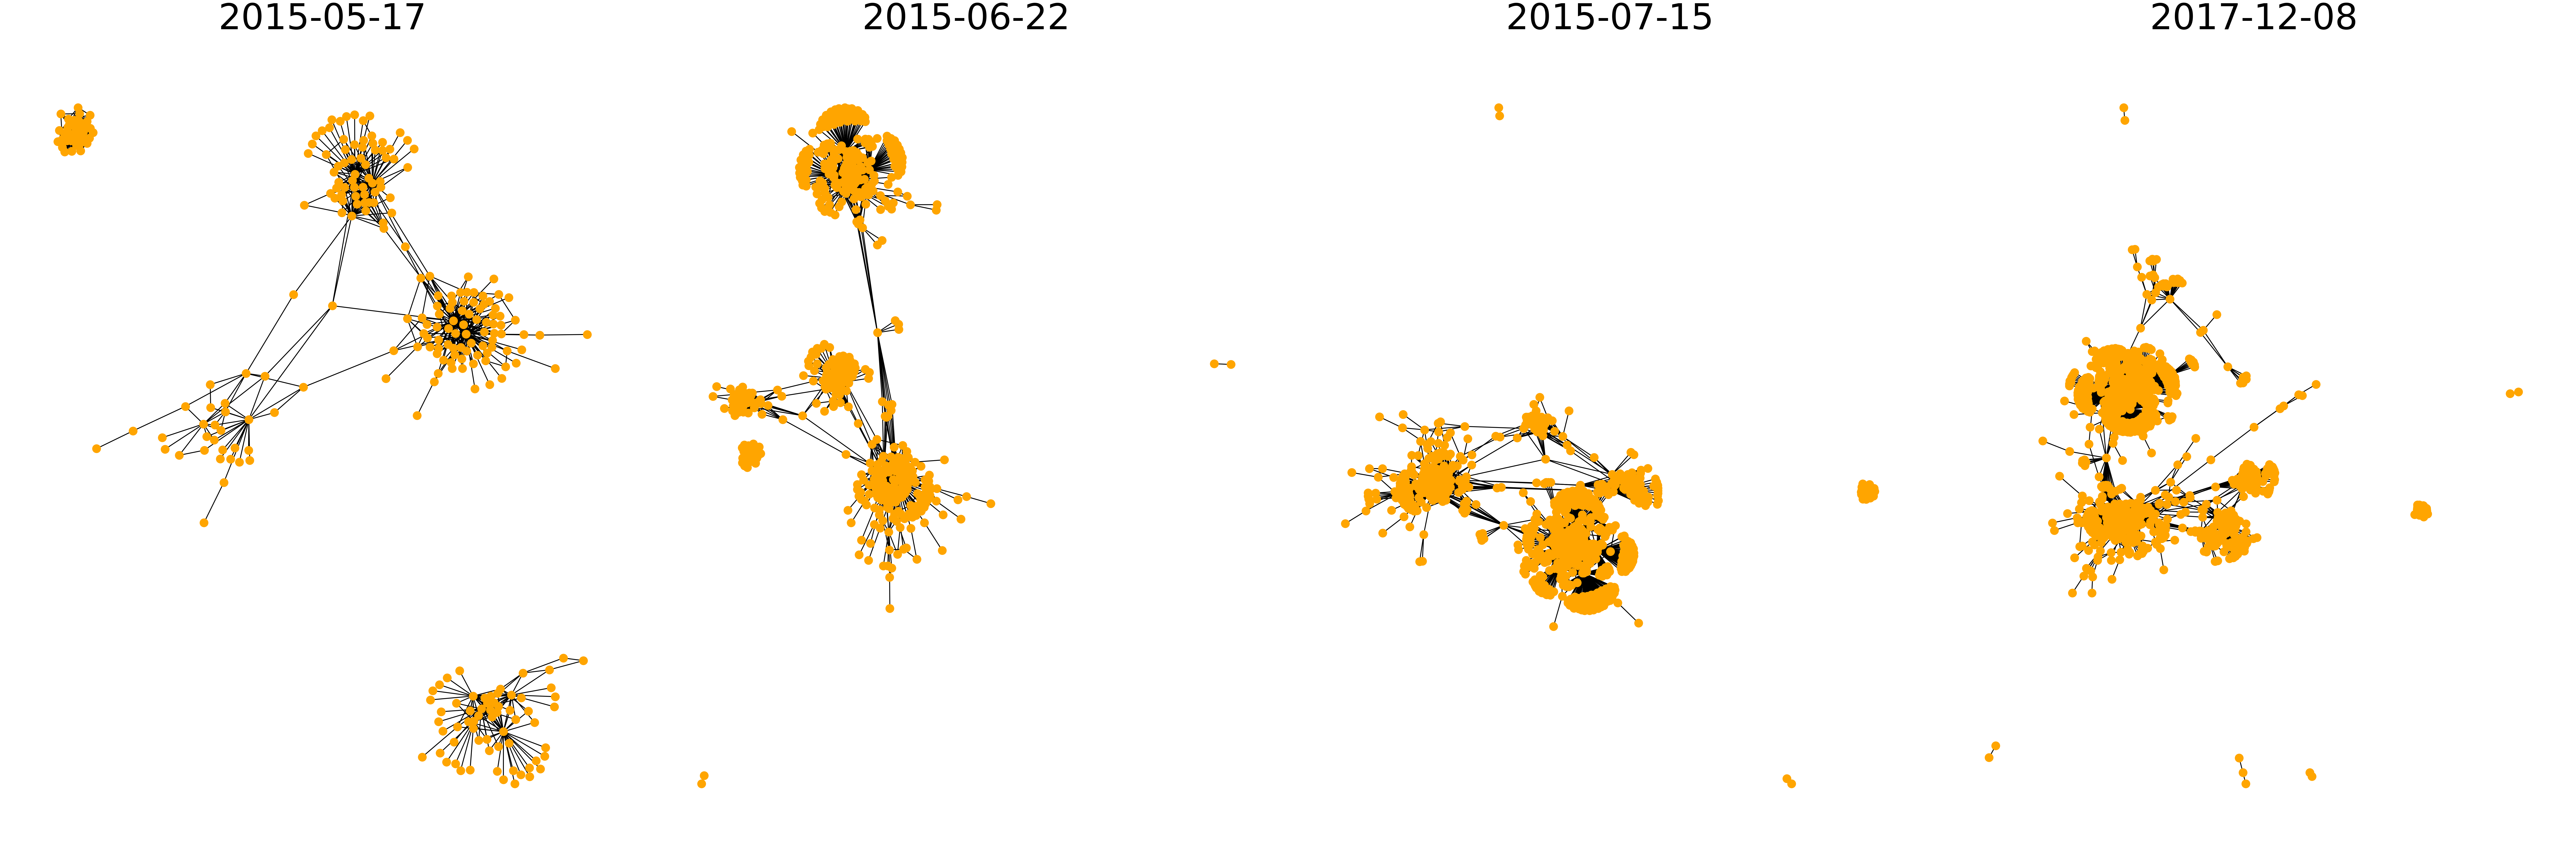

In [30]:
#plot graphs
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(120, 40))

nx.draw(G1, ax=axes[0], node_size=800, width = 3.0, node_color='orange')
nx.draw(G2, ax=axes[1], node_size=800, width = 3.0, node_color='orange')
nx.draw(G3, ax=axes[2], node_size=800, width = 3.0, node_color='orange')
nx.draw(G4, ax=axes[3], node_size=800, width = 3.0, node_color='orange')

axes[0].set_title('2015-05-17', fontsize=120)
axes[1].set_title('2015-06-22', fontsize=120)
axes[2].set_title('2015-07-15', fontsize=120)
axes[3].set_title('2017-12-08', fontsize=120)
    
plt.tight_layout()
plt.show()

In [31]:
#save the graph
fig.savefig('TimeSeriesAnalysis.png', dpi=300, bbox_inches='tight')

In [ ]:
#References:
#https://networkx.org/documentation/latest/tutorial.html
#https://matplotlib.org/cheatsheets/
#https://pandas.pydata.org/docs/user_guide/index.html
#https://docs.python.org/3/library/collections.html

In [9]:
pd.DataFrame(userData).to_csv("TrollsDataSet.csv", encoding='utf-8', index=False)
